In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')
all_df = pd.concat([train_df, test_df]).reset_index(drop=True)

In [2]:
all_df.isna().sum()

PassengerId       0
Survived        418
Pclass            0
Name              0
Sex               0
Age             263
SibSp             0
Parch             0
Ticket            0
Fare              1
Cabin          1014
Embarked          2
dtype: int64

In [3]:
from sklearn.preprocessing import OneHotEncoder

sex_encoder = OneHotEncoder(sparse_output=False)
sex_encoded = sex_encoder.fit_transform(all_df[['Sex']])
sex_df = pd.DataFrame(sex_encoded, columns=sex_encoder.get_feature_names_out(), dtype='int64')
all_df = pd.concat((all_df, sex_df), axis=1)
all_df

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Sex_female,Sex_male
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,0,1
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,1,0
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,1,0
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,1,0
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1304,1305,NaN,3,"Spector, Mr. Woolf",male,NaN,0,0,A.5. 3236,8.0500,NaN,S,0,1
1305,1306,NaN,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,C105,C,1,0
1306,1307,NaN,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S,0,1
1307,1308,NaN,3,"Ware, Mr. Frederick",male,NaN,0,0,359309,8.0500,NaN,S,0,1


In [4]:
from sklearn.preprocessing import PowerTransformer
from sklearn.ensemble import RandomForestRegressor

temp_df = all_df.copy()

fare_inlier = temp_df.loc[(temp_df['Fare'] != 0) & (~temp_df['Fare'].isna())]
fare_outlier = temp_df.loc[(temp_df['Fare'] == 0) | (temp_df['Fare'].isna())]

transformer = PowerTransformer()

X_train = fare_inlier[['Pclass', 'SibSp', 'Parch']]
X_test = fare_outlier[['Pclass', 'SibSp', 'Parch']]
y_train = transformer.fit_transform(fare_inlier.Fare.values.reshape(-1,1)).ravel()

fare_model = RandomForestRegressor()
fare_model.fit(X_train, y_train)

y_pred = fare_model.predict(X_test)

all_df.loc[(temp_df['Fare'] != 0) & (~temp_df['Fare'].isna()), 'Fare'] = y_train
all_df.loc[(temp_df['Fare'] == 0) | (temp_df['Fare'].isna()), 'Fare'] = y_pred

In [5]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.model_selection import cross_val_score

X = fare_inlier[['Pclass', 'SibSp', 'Parch']]
y = transformer.fit_transform(fare_inlier.Fare.values.reshape(-1,1)).ravel()

linear_model = LinearRegression()
print(cross_val_score(linear_model, X, y).mean())

rf_model = RandomForestRegressor()
print(cross_val_score(rf_model, X, y).mean())

svm_model = SVR()
print(cross_val_score(svm_model, X, y).mean())

0.7955736359518392
0.8211965617637752
0.8094708762173646


In [6]:
from sklearn.ensemble import RandomForestClassifier

temp_df = all_df.copy()

embarked_inlier = all_df[~all_df['Embarked'].isna()]
embarked_outlier = all_df[all_df['Embarked'].isna()]

X_names = ['Pclass', 'SibSp', 'Parch', 'Fare']
X_train = embarked_inlier[X_names]
X_test = embarked_outlier[X_names]
y_train = embarked_inlier['Embarked'].values

embark_model = RandomForestClassifier(class_weight='balanced_subsample')
embark_model.fit(X_train, y_train)
y_pred = embark_model.predict(X_test)

all_df.loc[all_df['Embarked'].isna(), 'Embarked'] = y_pred

In [7]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score

X = embarked_inlier[X_names]
y = embarked_inlier['Embarked'].values

logistic_model = LogisticRegression(max_iter=1000, class_weight='balanced')
print(cross_val_score(logistic_model, X, y).mean())

rf_model = RandomForestClassifier(class_weight='balanced_subsample')
print(cross_val_score(rf_model, X, y).mean())

svm_model = SVC(class_weight='balanced')
print(cross_val_score(svm_model, X, y).mean())

0.3779415635693604
0.9013102863326606
0.4391682021584627


In [8]:
embarked_encoder = OneHotEncoder(sparse_output=False)
embarked_encoded = embarked_encoder.fit_transform(all_df[['Embarked']])
embarked_df = pd.DataFrame(embarked_encoded, columns=embarked_encoder.get_feature_names_out(), dtype='int64')
all_df = pd.concat((all_df, embarked_df), axis=1)
all_df

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,-1.215092,NaN,S,0,1,0,0,1
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,1.370847,C85,C,1,0,1,0,0
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,-1.053615,NaN,S,1,0,0,0,1
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,1.183866,C123,S,1,0,0,0,1
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,-1.025820,NaN,S,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1304,1305,NaN,3,"Spector, Mr. Woolf",male,NaN,0,0,A.5. 3236,-1.025820,NaN,S,0,1,0,0,1
1305,1306,NaN,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,1.591007,C105,C,1,0,1,0,0
1306,1307,NaN,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,-1.215092,NaN,S,0,1,0,0,1
1307,1308,NaN,3,"Ware, Mr. Frederick",male,NaN,0,0,359309,-1.025820,NaN,S,0,1,0,0,1


In [9]:
from sklearn.svm import SVR

age_inliers = all_df[~all_df['Age'].isna()]
age_outliers = all_df[all_df['Age'].isna()]

X_train = age_inliers[['Pclass', 'Fare', 'SibSp', 'Parch']]
X_test = age_outliers[['Pclass', 'Fare', 'SibSp', 'Parch']]
y_train = age_inliers['Age'].values

age_model = SVR()
age_model.fit(X_train, y_train)

y_pred = age_model.predict(X_test)

all_df.loc[all_df['Age'].isna(), 'Age'] = y_pred

In [10]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.model_selection import cross_val_score

X = age_inliers[['Pclass', 'Fare', 'SibSp', 'Parch']]
y = age_inliers['Age'].values

linear_model = LinearRegression()
print(cross_val_score(linear_model, X, y).mean())

rf_model = RandomForestRegressor()
print(cross_val_score(rf_model, X, y).mean())

svm_model = SVR()
print(cross_val_score(svm_model, X, y).mean())

0.2096154758638352
0.17758948615203593
0.23971874540666066


In [11]:
train_df = all_df.iloc[:891]
train_df = train_df.astype({'Survived': 'int64'})
test_df = all_df.iloc[891:].reset_index(drop=True).drop('Survived', axis=1)

In [12]:
train_df

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
0,1,0,3,"Braund, Mr. Owen Harris",male,22.000000,1,0,A/5 21171,-1.215092,NaN,S,0,1,0,0,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.000000,1,0,PC 17599,1.370847,C85,C,1,0,1,0,0
2,3,1,3,"Heikkinen, Miss. Laina",female,26.000000,0,0,STON/O2. 3101282,-1.053615,NaN,S,1,0,0,0,1
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.000000,1,0,113803,1.183866,C123,S,1,0,0,0,1
4,5,0,3,"Allen, Mr. William Henry",male,35.000000,0,0,373450,-1.025820,NaN,S,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.000000,0,0,211536,-0.259146,NaN,S,0,1,0,0,1
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.000000,0,0,112053,0.722418,B42,S,1,0,0,0,1
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,18.719331,1,2,W./C. 6607,0.475343,NaN,S,1,0,0,0,1
889,890,1,1,"Behr, Mr. Karl Howell",male,26.000000,0,0,111369,0.722418,C148,C,0,1,1,0,0


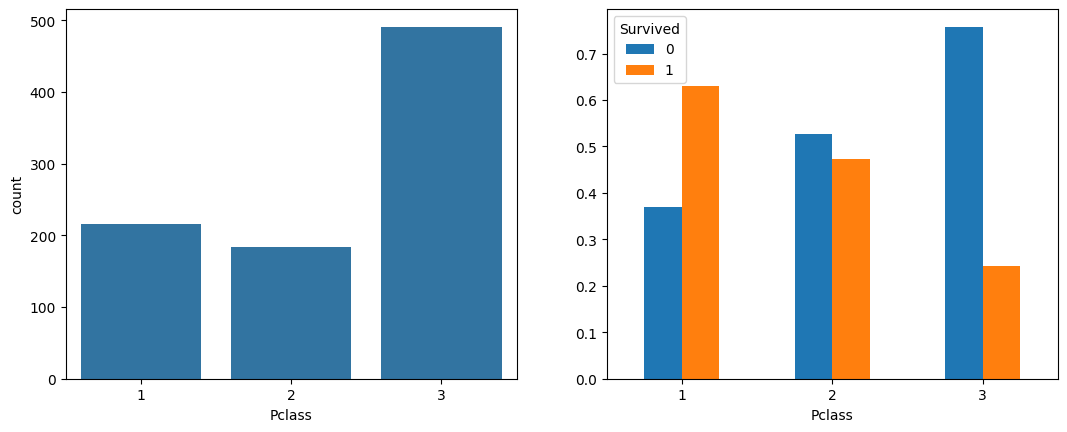

In [13]:
fig, ax = plt.subplots(1, 2, figsize=(12.8, 4.8))

sns.barplot(train_df.Pclass.value_counts(), ax=ax[0])
pd.crosstab(train_df.Pclass, train_df.Survived, normalize='index').plot(kind='bar', rot=0, ax=ax[1])
plt.show()

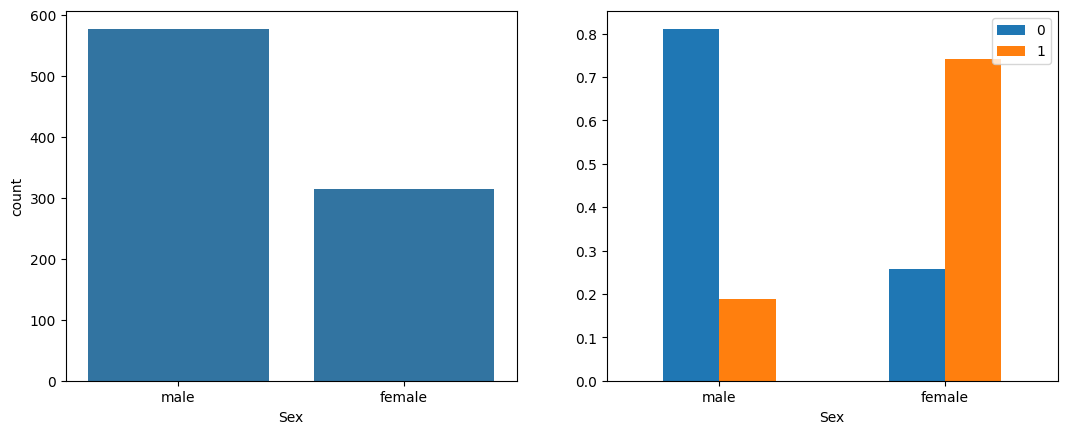

In [14]:
fig, ax = plt.subplots(1, 2, figsize=(12.8, 4.8))

sns.barplot(train_df.Sex.value_counts(), ax=ax[0])
pd.crosstab(train_df.Sex, train_df.Survived, normalize='index').reindex(['male', 'female']).plot(kind='bar', rot=0, ax=ax[1])
plt.legend(loc='upper right')
plt.show()

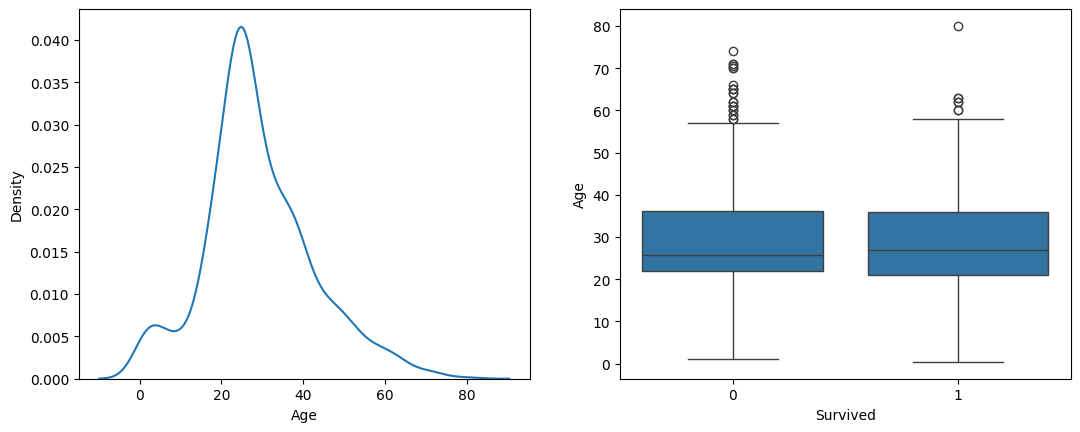

In [15]:
fig, ax = plt.subplots(1, 2, figsize=(12.8, 4.8))

sns.kdeplot(train_df.Age, ax=ax[0])
sns.boxplot(train_df, x='Survived', y='Age', ax=ax[1])
plt.show()

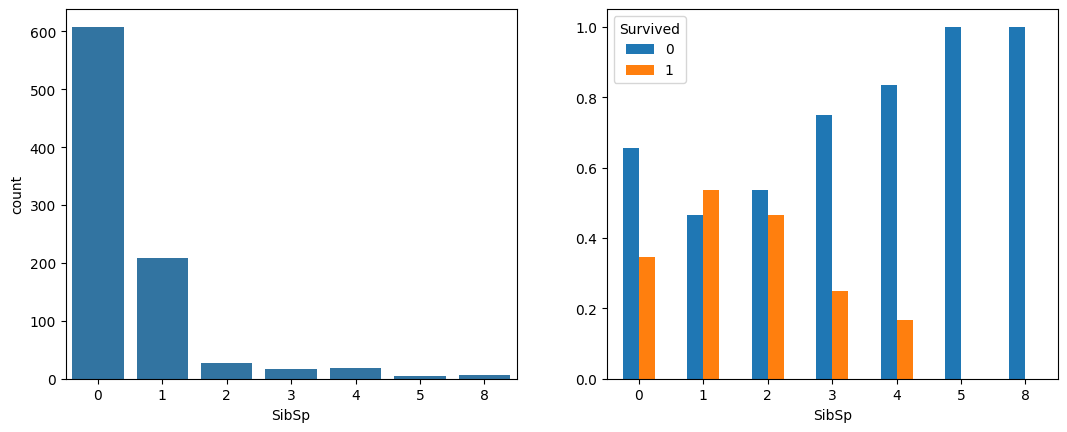

In [16]:
fig, ax = plt.subplots(1, 2, figsize=(12.8, 4.8))

sns.barplot(train_df.SibSp.value_counts(), ax=ax[0])
pd.crosstab(train_df.SibSp, train_df.Survived, normalize='index').plot(kind='bar', rot=0, ax=ax[1])
plt.show()

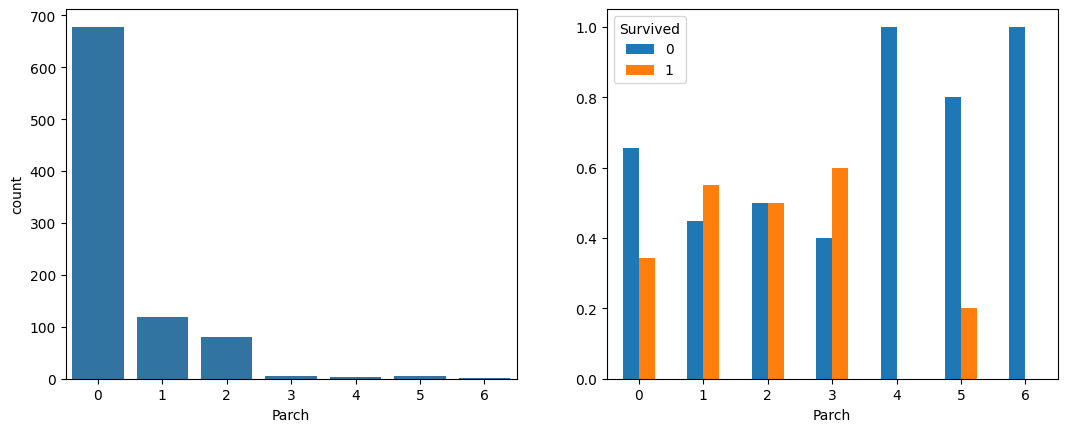

In [17]:
fig, ax = plt.subplots(1, 2, figsize=(12.8, 4.8))

sns.barplot(train_df.Parch.value_counts(), ax=ax[0])
pd.crosstab(train_df.Parch, train_df.Survived, normalize='index').plot(kind='bar', rot=0, ax=ax[1])
plt.show()

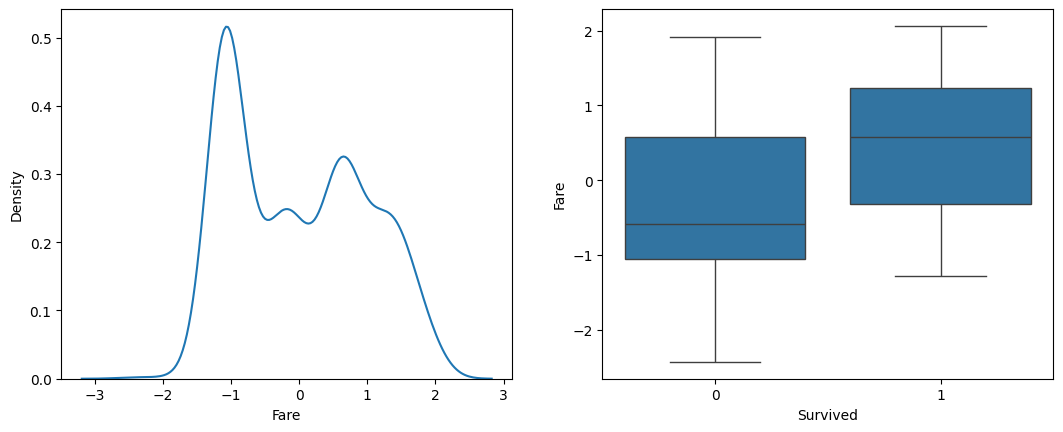

In [18]:
fig, ax = plt.subplots(1, 2, figsize=(12.8, 4.8))

sns.kdeplot(train_df.Fare, ax=ax[0])
sns.boxplot(train_df, x='Survived', y='Fare', ax=ax[1])
plt.show()

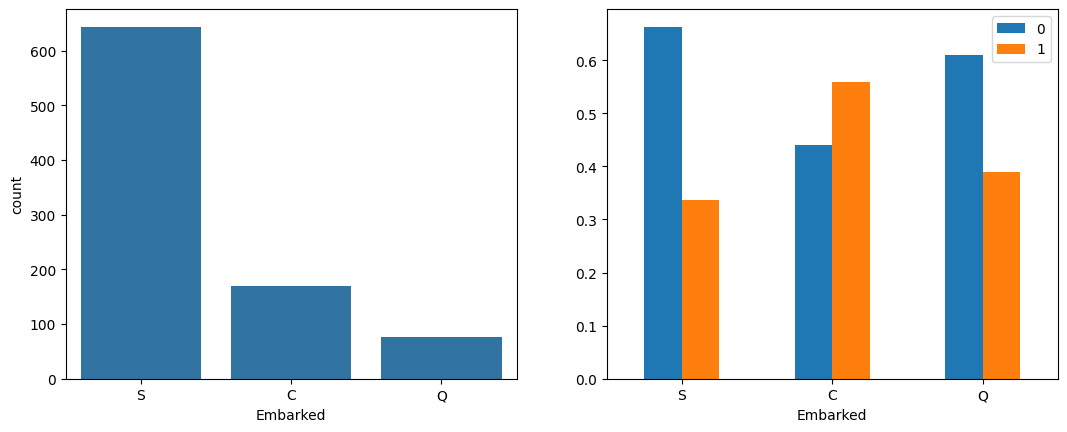

In [19]:
fig, ax = plt.subplots(1, 2, figsize=(12.8, 4.8))

sns.barplot(train_df.Embarked.value_counts(), ax=ax[0])
pd.crosstab(train_df.Embarked, train_df.Survived, normalize='index').reindex(['S', 'C', 'Q']).plot(kind='bar', rot=0, ax=ax[1])
plt.legend(loc='upper right')
plt.show()

In [20]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaled = scaler.fit_transform(train_df[['Pclass', 'Age', 'SibSp', 'Parch', 'Fare']])
scaled_df = pd.DataFrame(np.hstack((scaled, train_df[['Sex_female', 'Embarked_C', 'Embarked_Q']])), 
                         columns=[*scaler.feature_names_in_, 'Sex_female', 'Embarked_C', 'Embarked_Q'])

X = scaled_df
y = train_df['Survived'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

              precision    recall  f1-score   support

           0       0.84      0.78      0.81       110
           1       0.69      0.77      0.73        69

    accuracy                           0.78       179
   macro avg       0.77      0.77      0.77       179
weighted avg       0.78      0.78      0.78       179



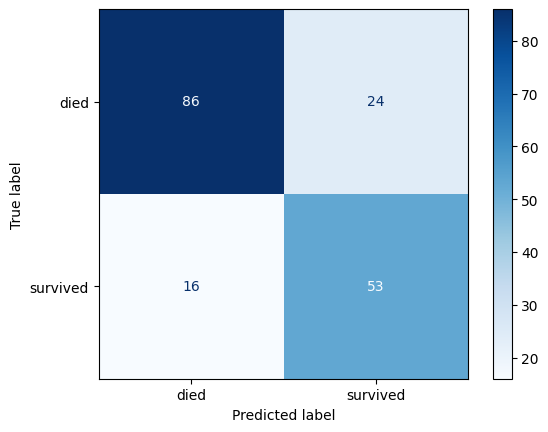

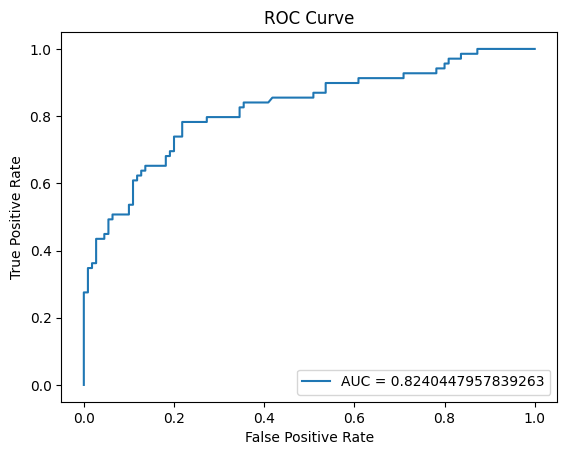

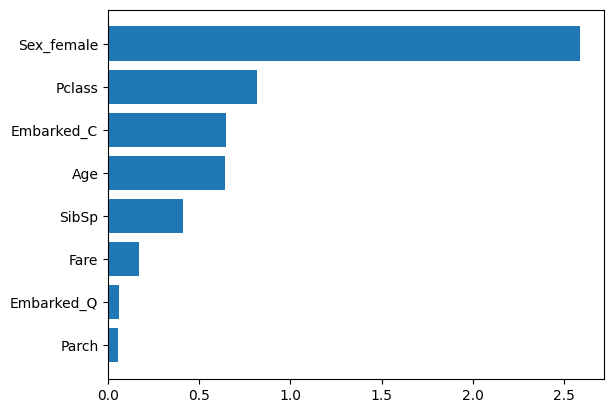

In [21]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

logistic_model = LogisticRegression(max_iter=1000, class_weight='balanced')
logistic_model.fit(X_train, y_train)

y_pred = logistic_model.predict(X_test)
y_proba = logistic_model.predict_proba(X_test)

print(metrics.classification_report(y_test, y_pred))

confusion_matrix = metrics.confusion_matrix(y_test, y_pred, labels=logistic_model.classes_)
display = metrics.ConfusionMatrixDisplay(confusion_matrix, display_labels=logistic_model.classes_)
display.plot(cmap='Blues')
x_locs, _ = plt.xticks()
y_locs, _ = plt.yticks()
plt.xticks(x_locs, ['died', 'survived'])
plt.yticks(y_locs, ['died', 'survived'])
plt.show()

fpr, tpr, _ = metrics.roc_curve(y_test, y_proba[:,1])
auc = metrics.roc_auc_score(y_test, y_proba[:,1])
plt.plot(fpr, tpr, label = f'AUC = {auc}')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

feature_importance = pd.Series(data=np.abs(logistic_model.coef_[0]), index=logistic_model.feature_names_in_).sort_values()
plt.barh(y=feature_importance.index, width=feature_importance)
plt.show()

              precision    recall  f1-score   support

           0       0.84      0.85      0.85       110
           1       0.76      0.74      0.75        69

    accuracy                           0.81       179
   macro avg       0.80      0.80      0.80       179
weighted avg       0.81      0.81      0.81       179



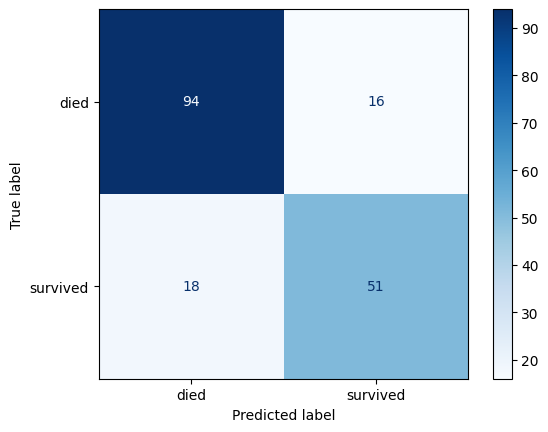

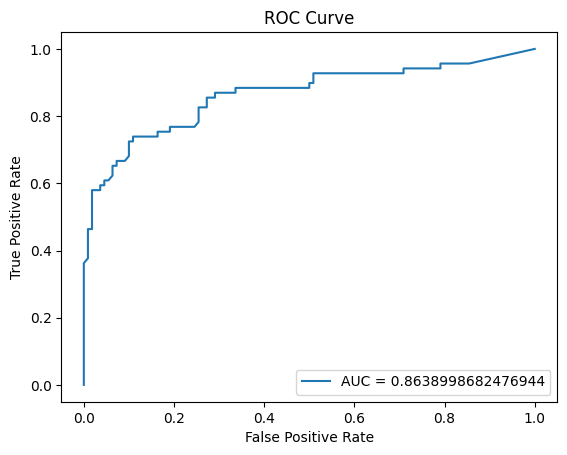

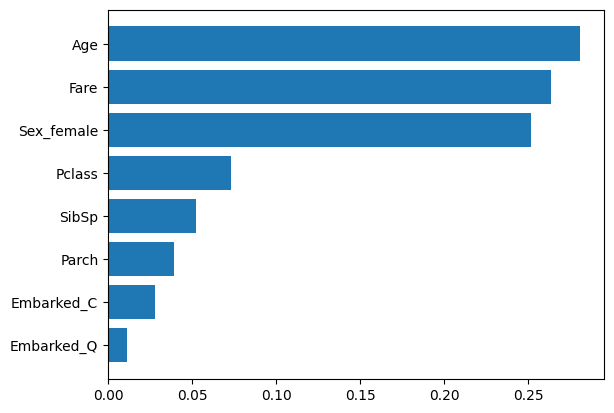

In [22]:
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(class_weight='balanced_subsample')
rf_model.fit(X_train, y_train)

y_pred = rf_model.predict(X_test)
y_proba = rf_model.predict_proba(X_test)

print(metrics.classification_report(y_test, y_pred))

confusion_matrix = metrics.confusion_matrix(y_test, y_pred, labels=rf_model.classes_)
display = metrics.ConfusionMatrixDisplay(confusion_matrix, display_labels=rf_model.classes_)
display.plot(cmap='Blues')
x_locs, _ = plt.xticks()
y_locs, _ = plt.yticks()
plt.xticks(x_locs, ['died', 'survived'])
plt.yticks(y_locs, ['died', 'survived'])
plt.show()

fpr, tpr, _ = metrics.roc_curve(y_test, y_proba[:,1])
auc = metrics.roc_auc_score(y_test, y_proba[:,1])
plt.plot(fpr, tpr, label = f'AUC = {auc}')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

feature_importance = pd.Series(data=np.abs(rf_model.feature_importances_), index=rf_model.feature_names_in_).sort_values()
plt.barh(y=feature_importance.index, width=feature_importance)
plt.show()

              precision    recall  f1-score   support

           0       0.81      0.83      0.82       110
           1       0.71      0.68      0.70        69

    accuracy                           0.77       179
   macro avg       0.76      0.75      0.76       179
weighted avg       0.77      0.77      0.77       179



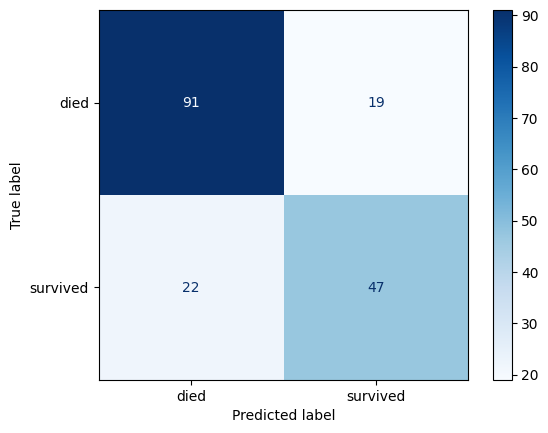

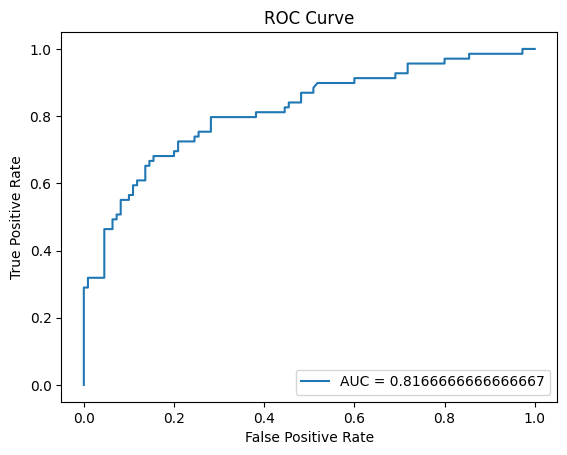

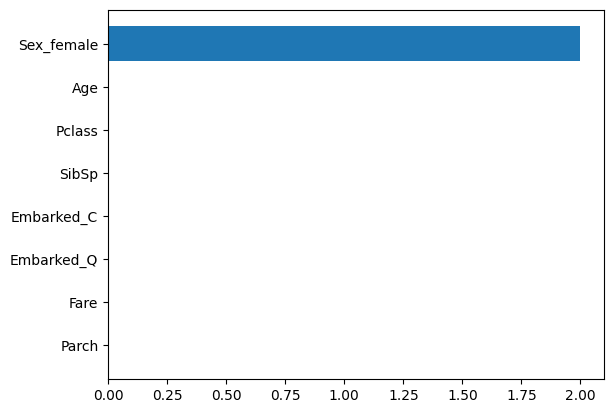

In [23]:
from sklearn.svm import SVC

svm_model = SVC(kernel='linear', class_weight='balanced', probability=True)
svm_model.fit(X_train, y_train)

y_pred = svm_model.predict(X_test)
y_proba = svm_model.predict_proba(X_test)

print(metrics.classification_report(y_test, y_pred))

confusion_matrix = metrics.confusion_matrix(y_test, y_pred, labels=svm_model.classes_)
display = metrics.ConfusionMatrixDisplay(confusion_matrix, display_labels=svm_model.classes_)
display.plot(cmap='Blues')
x_locs, _ = plt.xticks()
y_locs, _ = plt.yticks()
plt.xticks(x_locs, ['died', 'survived'])
plt.yticks(y_locs, ['died', 'survived'])
plt.show()

fpr, tpr, _ = metrics.roc_curve(y_test, y_proba[:,1])
auc = metrics.roc_auc_score(y_test, y_proba[:,1])
plt.plot(fpr, tpr, label = f'AUC = {auc}')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

feature_importance = pd.Series(data=np.abs(svm_model.coef_[0]), index=rf_model.feature_names_in_).sort_values()
plt.barh(y=feature_importance.index, width=feature_importance)
plt.show()